In [1]:
import sys
from importlib import reload 
sys.path.append('./lib')

In [2]:
import utils  # expand_to_hyperboloid
utils = reload(utils)

import distances  # Distances, DistancesAggregator, ProductDistances
distances = reload(distances)
from distances import Distances, ProductDistances

import dssm  # DSSM_V2, JustEmbedding
dssm = reload(dssm)

import layers  # SphericalExponentialMapLayer, HyperbolicalExponentialMapLayer
layers = reload(layers)

In [3]:
utils.self_tests()

expand_to_hyperboloid unittest #1


In [4]:
distances.self_tests()

DistancesAggregator unittest #1...
DistancesAggregator unittest #2...
ProductDistances unittest #1...
ProductDistances unittest #2...
ProductDistances unittest #3...
ProductDistances unittest #4...
str(pd) = E2,S3,H3


In [5]:
layers.self_tests()

SphericalExponentialMapLayer UT 1
SphericalExponentialMapLayer UT 2
HyperbolicalExponentialMapLayer UT 1
HyperbolicalExponentialMapLayer UT 2


________________________

In [6]:
import networkx as nx
import numpy as np
import tensorflow as tf
import tqdm

assert int(tf.__version__.split(".")[0]) >= 2

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [7]:
def make_model(l=312):
    return dssm.JustEmbedding(l, emb_size=10)

def make_model_2(emb_size=10, l=312):
    return dssm.JustEmbedding(l, emb_size=emb_size)

def make_distances(for_ranking=True):
    return [
        ProductDistances([
            (10, Distances("euclidian_corrected", scalable=False))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l0_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1_sq_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("inverted_dot", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("expanded_hyp", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("spherical", scalable=True))
        ], "sum"),
        ProductDistances([
            (5, Distances("expanded_hyp", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (5, Distances("spherical", scalable=True)),
            (5, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (5, Distances("spherical", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("euclidian", scalable=True)),
        ]),
    ]


def make_distances_3():
    return [
        ProductDistances([
            (11, Distances("spherical", scalable=True))
        ], "sum"),
        ProductDistances([
            (6, Distances("spherical", scalable=True)),
            (6, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (6, Distances("spherical", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("euclidian", scalable=True)),
        ]),
    ]


def make_distances_exp_dot(k=1):
    return [
        ProductDistances([
            (10, Distances("exp_minus_dot", scalable=True))
        ], "sum")
        for _ in range(k)
    ]


def make_distances_4():
    # only not-corrected ttl1 metrices
    return [
        ProductDistances([
            (10, Distances("triple_trainable_l1_sq", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1", scalable=True))
        ], "sum"),
    ]

_____________


### USCA312 fake product spaces example
**(no exponential map, just default gradients & adam optimizer)**

In [8]:
_, distances_matrix = utils.get_dataset("usca312")

Loading from ../datasets/usca312.edges


In [9]:
d = make_model()
qs = d.sparse_arange(312)  # queries
# r_matrix = 1 * (distances_matrix <= 1.001)  ## BUGS EVERYWHERE
distances_matrix.shape

(312, 312)

In [10]:
distances_matrix

array([[0.   , 1.167, 1.579, ..., 1.209, 0.866, 1.112],
       [1.167, 0.   , 0.413, ..., 0.045, 1.904, 0.082],
       [1.579, 0.413, 0.   , ..., 0.37 , 2.312, 0.467],
       ...,
       [1.209, 0.045, 0.37 , ..., 0.   , 1.95 , 0.107],
       [0.866, 1.904, 2.312, ..., 1.95 , 0.   , 1.87 ],
       [1.112, 0.082, 0.467, ..., 0.107, 1.87 , 0.   ]])

In [11]:
dm_copy = np.copy(distances_matrix)
r_matrix = np.copy(distances_matrix)

for i in range(dm_copy.shape[0]):
    dm_copy[i].sort()
    r_matrix[i] = distances_matrix[i] <= dm_copy[i, 1] + 1e-3
r_matrix -= np.eye(r_matrix.shape[0])

In [12]:
distances_matrix

array([[0.   , 1.167, 1.579, ..., 1.209, 0.866, 1.112],
       [1.167, 0.   , 0.413, ..., 0.045, 1.904, 0.082],
       [1.579, 0.413, 0.   , ..., 0.37 , 2.312, 0.467],
       ...,
       [1.209, 0.045, 0.37 , ..., 0.   , 1.95 , 0.107],
       [0.866, 1.904, 2.312, ..., 1.95 , 0.   , 1.87 ],
       [1.112, 0.082, 0.467, ..., 0.107, 1.87 , 0.   ]])

In [13]:
r_matrix.sum(-1)  # edges per vertex

array([1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       1., 1., 1., 1., 1.

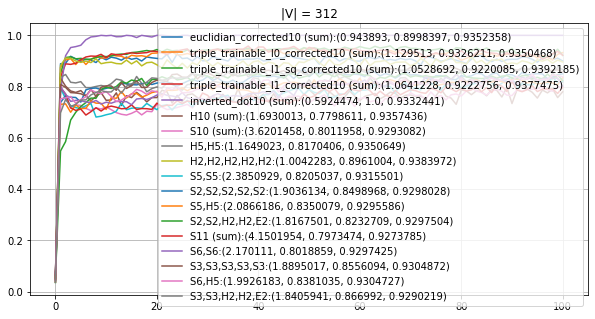


0.8998397	euclidian_corrected10 (sum)
0.9326211	triple_trainable_l0_corrected10 (sum)
0.9220085	triple_trainable_l1_sq_corrected10 (sum)
0.9222756	triple_trainable_l1_corrected10 (sum)
1.0	inverted_dot10 (sum)
0.7798611	H10 (sum)
0.8011958	S10 (sum)
0.8170406	H5,H5
0.8961004	H2,H2,H2,H2,H2
0.8205037	S5,S5
0.8498968	S2,S2,S2,S2,S2
0.8350079	S5,H5
0.8232709	S2,S2,H2,H2,E2
0.7973474	S11 (sum)
0.8018859	S6,S6
0.8556094	S3,S3,S3,S3,S3
0.8381035	S6,H5
0.866992	S3,S3,H2,H2,E2


In [15]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.01,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="softmax_1/dist"
)

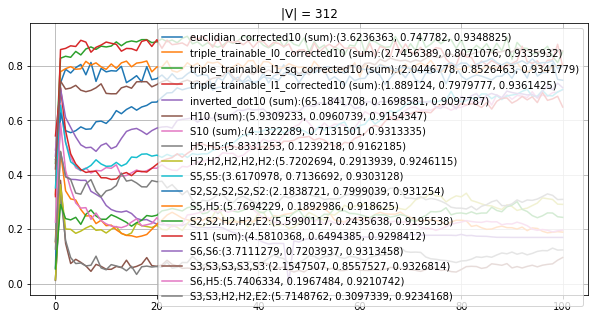


0.747782	euclidian_corrected10 (sum)
0.8071076	triple_trainable_l0_corrected10 (sum)
0.8526463	triple_trainable_l1_sq_corrected10 (sum)
0.7979777	triple_trainable_l1_corrected10 (sum)
0.1698581	inverted_dot10 (sum)
0.0960739	H10 (sum)
0.7131501	S10 (sum)
0.1239218	H5,H5
0.2913939	H2,H2,H2,H2,H2
0.7136692	S5,S5
0.7999039	S2,S2,S2,S2,S2
0.1892986	S5,H5
0.2435638	S2,S2,H2,H2,E2
0.6494385	S11 (sum)
0.7203937	S6,S6
0.8557527	S3,S3,S3,S3,S3
0.1967484	S6,H5
0.3097339	S3,S3,H2,H2,E2


In [16]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="softmax_1/dist"
)

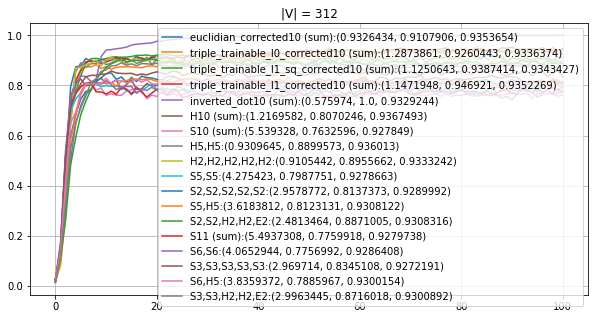


0.9107906	euclidian_corrected10 (sum)
0.9260443	triple_trainable_l0_corrected10 (sum)
0.9387414	triple_trainable_l1_sq_corrected10 (sum)
0.946921	triple_trainable_l1_corrected10 (sum)
1.0	inverted_dot10 (sum)
0.8070246	H10 (sum)
0.7632596	S10 (sum)
0.8899573	H5,H5
0.8955662	H2,H2,H2,H2,H2
0.7987751	S5,S5
0.8137373	S2,S2,S2,S2,S2
0.8123131	S5,H5
0.8871005	S2,S2,H2,H2,E2
0.7759918	S11 (sum)
0.7756992	S6,S6
0.8345108	S3,S3,S3,S3,S3
0.7885967	S6,H5
0.8716018	S3,S3,H2,H2,E2


In [18]:
total_loss_story3 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.001,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="softmax_1/dist"
)

In [20]:
for d, l0, l1, l2 in zip(make_distances()+make_distances_3(), total_loss_story, total_loss_story2, total_loss_story3):
    ar = np.array([x[-1] for x in [l0, l1, l2]])
    # print(f"{ar[:, 0].argmin(), ar[:, 1:].argmax(axis=0)}\t{d}")
    print(f"{ar[:, 0].min(), *ar[:, 1:].max(axis=0)}\t{d}")

(0.9326434, 0.9107906, 0.9353654)	euclidian_corrected10 (sum)
(1.129513, 0.9326211, 0.9350468)	triple_trainable_l0_corrected10 (sum)
(1.0528692, 0.9387414, 0.9392185)	triple_trainable_l1_sq_corrected10 (sum)
(1.0641228, 0.946921, 0.9377475)	triple_trainable_l1_corrected10 (sum)
(0.575974, 1.0, 0.9332441)	inverted_dot10 (sum)
(1.2169582, 0.8070246, 0.9367493)	H10 (sum)
(3.6201458, 0.8011958, 0.9313335)	S10 (sum)
(0.9309645, 0.8899573, 0.936013)	H5,H5
(0.9105442, 0.8961004, 0.9383972)	H2,H2,H2,H2,H2
(2.3850929, 0.8205037, 0.9315501)	S5,S5
(1.9036134, 0.8498968, 0.931254)	S2,S2,S2,S2,S2
(2.0866186, 0.8350079, 0.9308122)	S5,H5
(1.8167501, 0.8871005, 0.9308316)	S2,S2,H2,H2,E2
(4.1501954, 0.7973474, 0.9298412)	S11 (sum)
(2.170111, 0.8018859, 0.9313458)	S6,S6
(1.8895017, 0.8557527, 0.9326814)	S3,S3,S3,S3,S3
(1.9926183, 0.8381035, 0.9304727)	S6,H5
(1.8405941, 0.8716018, 0.9300892)	S3,S3,H2,H2,E2


__________________

# CS PhDs

In [25]:
G, distances_matrix,r_matrix = utils.get_dataset(distances_matrix=True, edges_matrix=True)

Loading from ../datasets/CSPhDs.edges
|V| = 1025, |E| = 1043


In [26]:
make_model_g = lambda : make_model(len(G.nodes()))
d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))

In [27]:
r_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
distances_matrix

array([[ 0,  1,  2, ..., 17, 17, 17],
       [ 1,  0,  1, ..., 16, 16, 16],
       [ 2,  1,  0, ..., 16, 16, 16],
       ...,
       [17, 16, 16, ...,  0,  2,  2],
       [17, 16, 16, ...,  2,  0,  2],
       [17, 16, 16, ...,  2,  2,  0]])

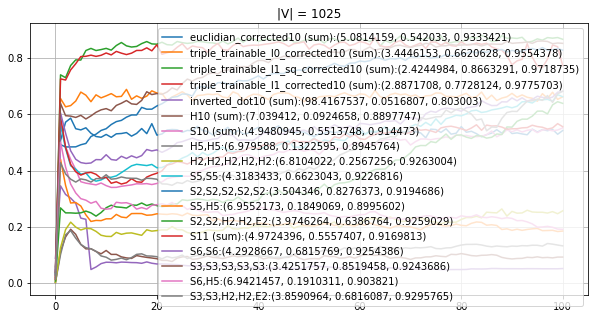

0.542033	euclidian_corrected10 (sum)
0.6620628	triple_trainable_l0_corrected10 (sum)
0.8663291	triple_trainable_l1_sq_corrected10 (sum)
0.7728124	triple_trainable_l1_corrected10 (sum)
0.0516807	inverted_dot10 (sum)
0.0924658	H10 (sum)
0.5513748	S10 (sum)
0.1322595	H5,H5
0.2567256	H2,H2,H2,H2,H2
0.6623043	S5,S5
0.8276373	S2,S2,S2,S2,S2
0.1849069	S5,H5
0.6386764	S2,S2,H2,H2,E2
0.5557407	S11 (sum)
0.6815769	S6,S6
0.8519458	S3,S3,S3,S3,S3
0.1910311	S6,H5
0.6816087	S3,S3,H2,H2,E2


In [30]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="softmax_1/dist"
)

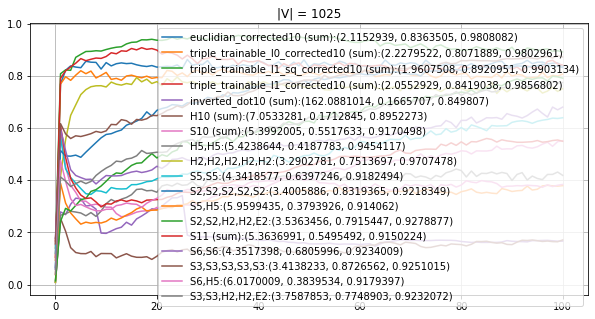

0.8363505	euclidian_corrected10 (sum)
0.8071889	triple_trainable_l0_corrected10 (sum)
0.8920951	triple_trainable_l1_sq_corrected10 (sum)
0.8419038	triple_trainable_l1_corrected10 (sum)
0.1665707	inverted_dot10 (sum)
0.1712845	H10 (sum)
0.5517633	S10 (sum)
0.4187783	H5,H5
0.7513697	H2,H2,H2,H2,H2
0.6397246	S5,S5
0.8319365	S2,S2,S2,S2,S2
0.3793926	S5,H5
0.7915447	S2,S2,H2,H2,E2
0.5495492	S11 (sum)
0.6805996	S6,S6
0.8726562	S3,S3,S3,S3,S3
0.3839534	S6,H5
0.7748903	S3,S3,H2,H2,E2


In [32]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.05,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="softmax_1/dist"
)

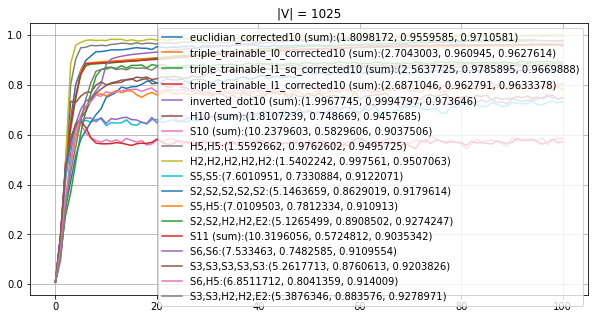

0.9559585	euclidian_corrected10 (sum)
0.960945	triple_trainable_l0_corrected10 (sum)
0.9785895	triple_trainable_l1_sq_corrected10 (sum)
0.962791	triple_trainable_l1_corrected10 (sum)
0.9994797	inverted_dot10 (sum)
0.748669	H10 (sum)
0.5829606	S10 (sum)
0.9762602	H5,H5
0.997561	H2,H2,H2,H2,H2
0.7330884	S5,S5
0.8629019	S2,S2,S2,S2,S2
0.7812334	S5,H5
0.8908502	S2,S2,H2,H2,E2
0.5724812	S11 (sum)
0.7482585	S6,S6
0.8760613	S3,S3,S3,S3,S3
0.8041359	S6,H5
0.883576	S3,S3,H2,H2,E2


In [34]:
total_loss_story3 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.001,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="softmax_1/dist"
)

In [35]:
for d, l0, l1, l2 in zip(make_distances()+make_distances_3(), total_loss_story, total_loss_story2, total_loss_story3):
    ar = np.array([x[-1] for x in [l0, l1, l2]])
    # print(f"{ar[:, 0].argmin(), ar[:, 1:].argmax(axis=0)}\t{d}")
    print(f"{ar[:, 0].min(), *ar[:, 1:].max(axis=0)}\t{d}")

(1.8098172, 0.9559585, 0.9808082)	euclidian_corrected10 (sum)
(2.2279522, 0.960945, 0.9802961)	triple_trainable_l0_corrected10 (sum)
(1.9607508, 0.9785895, 0.9903134)	triple_trainable_l1_sq_corrected10 (sum)
(2.0552929, 0.962791, 0.9856802)	triple_trainable_l1_corrected10 (sum)
(1.9967745, 0.9994797, 0.973646)	inverted_dot10 (sum)
(1.8107239, 0.748669, 0.9457685)	H10 (sum)
(4.9480945, 0.5829606, 0.9170498)	S10 (sum)
(1.5592662, 0.9762602, 0.9495725)	H5,H5
(1.5402242, 0.997561, 0.9707478)	H2,H2,H2,H2,H2
(4.3183433, 0.7330884, 0.9226816)	S5,S5
(3.4005886, 0.8629019, 0.9218349)	S2,S2,S2,S2,S2
(5.9599435, 0.7812334, 0.914062)	S5,H5
(3.5363456, 0.8908502, 0.9278877)	S2,S2,H2,H2,E2
(4.9724396, 0.5724812, 0.9169813)	S11 (sum)
(4.2928667, 0.7482585, 0.9254386)	S6,S6
(3.4138233, 0.8760613, 0.9251015)	S3,S3,S3,S3,S3
(6.0170009, 0.8041359, 0.9179397)	S6,H5
(3.7587853, 0.883576, 0.9295765)	S3,S3,H2,H2,E2


__________________

# POWER

In [36]:
G, distances_matrix, r_matrix = utils.get_dataset("power", distances_matrix=True, edges_matrix=True)

Loading from ../datasets/power.edges
|V| = 4941, |E| = 6594


In [37]:
distances_matrix

array([[ 0,  1,  1, ..., 10, 14, 14],
       [ 1,  0,  2, ...,  9, 13, 13],
       [ 1,  2,  0, ..., 11, 15, 15],
       ...,
       [10,  9, 11, ...,  0, 11, 11],
       [14, 13, 15, ..., 11,  0,  2],
       [14, 13, 15, ..., 11,  2,  0]])

In [38]:
r_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
make_model_g = lambda : make_model(len(G.nodes()))
def make_model_g2(emb_size=10):
    return make_model_2(emb_size=emb_size, l=len(G.nodes()))

d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))  # queries

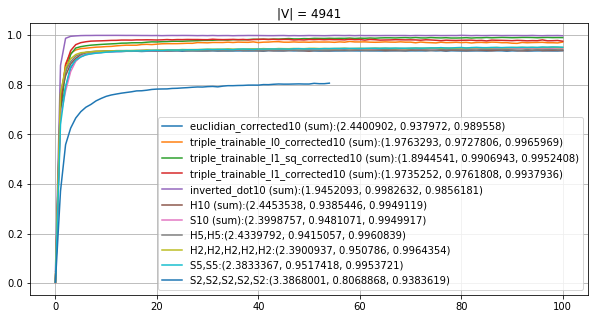

1081:3.3867367100123658
1082:3.386651451815896
1083:3.3866519385972764
1084:3.386582043988382
1085:3.3865655849556653
1086:3.3865375588594406
1087:3.386509584635443
1088:3.386450886180615
1089:3.386457790675695
1090:3.3863936869716644
1091:3.3863516914407703
1092:3.386371374490824
1093:3.3863041914539553
1094:3.386272521478716
1095:3.386277216642695


In [ ]:
total_loss_story_p1 = utils.estimate_signatures_softmax(
    make_model, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20
)

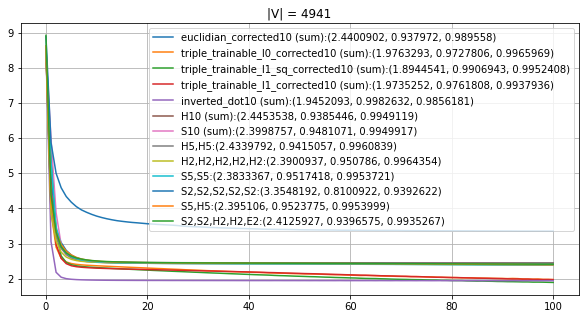

In [21]:
# fuck'in connection (image )
dists = make_distances()
plt.figure(figsize=(10, 5))
plt.title(f"|V| = {qs.shape[0]}")
for i, prev_loss_story in enumerate(total_loss_story_p1):
    plt.plot([x[0] for x in prev_loss_story], label=f"{dists[i]}:{prev_loss_story[-1]}")
plt.legend()
plt.grid()
clear_output()
plt.show()

In [26]:
for d, l in zip(make_distances(), total_loss_story_p1):
    print(f"{l[-1]}\t{d}")

(2.4400902, 0.937972, 0.989558)	euclidian_corrected10 (sum)
(1.9763293, 0.9727806, 0.9965969)	triple_trainable_l0_corrected10 (sum)
(1.8944541, 0.9906943, 0.9952408)	triple_trainable_l1_sq_corrected10 (sum)
(1.9735252, 0.9761808, 0.9937936)	triple_trainable_l1_corrected10 (sum)
(1.9452093, 0.9982632, 0.9856181)	inverted_dot10 (sum)
(2.4453538, 0.9385446, 0.9949119)	H10 (sum)
(2.3998757, 0.9481071, 0.9949917)	S10 (sum)
(2.4339792, 0.9415057, 0.9960839)	H5,H5
(2.3900937, 0.950786, 0.9964354)	H2,H2,H2,H2,H2
(2.3833367, 0.9517418, 0.9953721)	S5,S5
(3.3548192, 0.8100922, 0.9392622)	S2,S2,S2,S2,S2
(2.395106, 0.9523775, 0.9953999)	S5,H5
(2.4125927, 0.9396575, 0.9935267)	S2,S2,H2,H2,E2


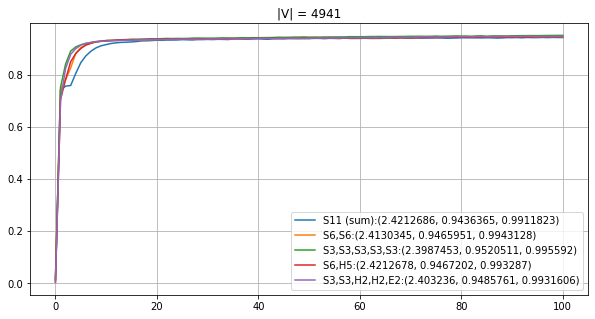

0.9436365	S11 (sum)
0.9465951	S6,S6
0.9520511	S3,S3,S3,S3,S3
0.9467202	S6,H5
0.9485761	S3,S3,H2,H2,E2


In [35]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances_3(), iters=2000, learning_rate=0.05,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

_______________________

# Facebook

In [36]:
G, distances_matrix = utils.get_dataset("facebook", distances_matrix=True)

Loading from ../datasets/facebook.edges
|V| = 4039, |E| = 88234


In [37]:
make_model_g = lambda : make_model(len(G.nodes()))
def make_model_g2(emb_size=10):
    return make_model_2(emb_size=emb_size, l=len(G.nodes()))

d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))  # queries
r_matrix = 1 * (distances_matrix <= 1.001)
distances_matrix.shape

(4039, 4039)

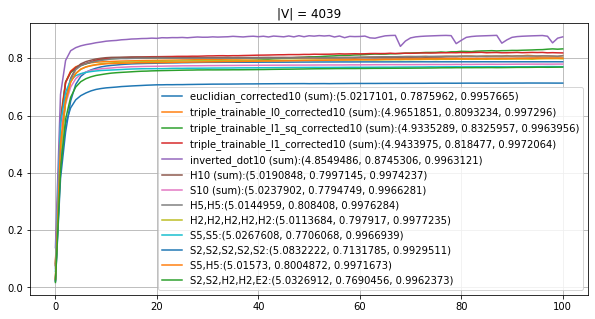

In [29]:
total_loss_story_f1 = utils.estimate_signatures_softmax(
    make_model, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20
)

In [34]:
for d, l in zip(make_distances(), total_loss_story_f1):
    print(f"{l[-1]}\t{d}")

(5.0217101, 0.7875962, 0.9957665)	euclidian_corrected10 (sum)
(4.9651851, 0.8093234, 0.997296)	triple_trainable_l0_corrected10 (sum)
(4.9335289, 0.8325957, 0.9963956)	triple_trainable_l1_sq_corrected10 (sum)
(4.9433975, 0.818477, 0.9972064)	triple_trainable_l1_corrected10 (sum)
(4.8549486, 0.8745306, 0.9963121)	inverted_dot10 (sum)
(5.0190848, 0.7997145, 0.9974237)	H10 (sum)
(5.0237902, 0.7794749, 0.9966281)	S10 (sum)
(5.0144959, 0.808408, 0.9976284)	H5,H5
(5.0113684, 0.797917, 0.9977235)	H2,H2,H2,H2,H2
(5.0267608, 0.7706068, 0.9966939)	S5,S5
(5.0832222, 0.7131785, 0.9929511)	S2,S2,S2,S2,S2
(5.01573, 0.8004872, 0.9971673)	S5,H5
(5.0326912, 0.7690456, 0.9962373)	S2,S2,H2,H2,E2


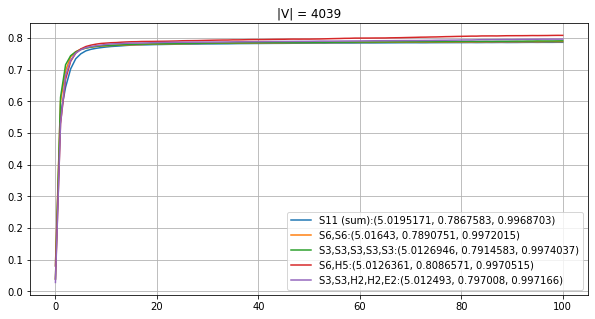

0.7867583	S11 (sum)
0.7890751	S6,S6
0.7914583	S3,S3,S3,S3,S3
0.8086571	S6,H5
0.797008	S3,S3,H2,H2,E2


In [38]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

______________________
## Wiki 
### aka WLA6 - bfs on Wikipedia categories from Linear Algebra, depth = 6

In [40]:
# !cp wiki.edges ../datasets/wla6.edges
# !cp wiki.nodes ../datasets/wla6.nodes

In [41]:
!head ../datasets/wla6.edges -n 3
!echo 
!head ../datasets/wla6.nodes -n 4

0	1
0	2
0	3

linear algebra
convex geometry
determinants
invariant subspaces


In [42]:
G, distances_matrix, r_matrix = utils.get_dataset("wla6", distances_matrix=True, edges_matrix=True)

Loading from ../datasets/wla6.edges
|V| = 3227, |E| = 3604


In [43]:
make_model_g = lambda : make_model(len(G.nodes()))
def make_model_g2(emb_size=10):
    return make_model_2(emb_size=emb_size, l=len(G.nodes()))

d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))  # queries

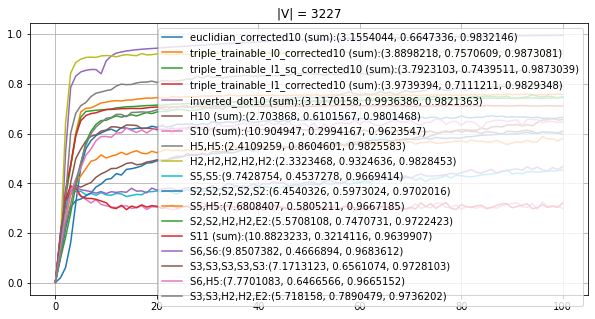

0.6647336	euclidian_corrected10 (sum)
0.7570609	triple_trainable_l0_corrected10 (sum)
0.7439511	triple_trainable_l1_sq_corrected10 (sum)
0.7111211	triple_trainable_l1_corrected10 (sum)
0.9936386	inverted_dot10 (sum)
0.6101567	H10 (sum)
0.2994167	S10 (sum)
0.8604601	H5,H5
0.9324636	H2,H2,H2,H2,H2
0.4537278	S5,S5
0.5973024	S2,S2,S2,S2,S2
0.5805211	S5,H5
0.7470731	S2,S2,H2,H2,E2
0.3214116	S11 (sum)
0.4666894	S6,S6
0.6561074	S3,S3,S3,S3,S3
0.6466566	S6,H5
0.7890479	S3,S3,H2,H2,E2


In [46]:
total_loss_story_w = utils.estimate_signatures_softmax(
    make_model_g2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.001,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="softmax_1/dist"
)

In [ ]:
for d, l in zip(make_distances(), total_loss_story_w):
    print(f"{l[-1]}\t{d}")

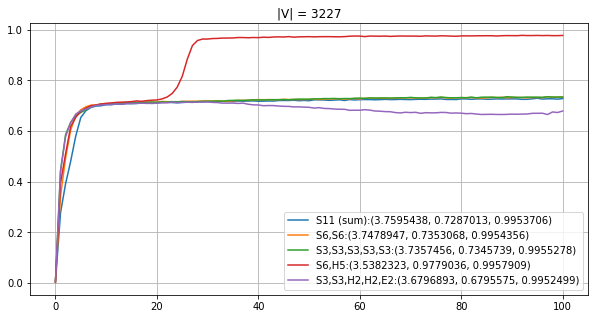

0.7287013	S11 (sum)
0.7353068	S6,S6
0.7345739	S3,S3,S3,S3,S3
0.9779036	S6,H5
0.6795575	S3,S3,H2,H2,E2


In [43]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)